In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,Conv2DTranspose, Conv2D, Dense, Flatten,InputLayer, Input)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Data Prepration

In [2]:
(x_train,_),(x_test,_)=tf.keras.datasets.mnist.load_data()
x_train=np.expand_dims(x_train,-1).astype('float32')/255
x_test=np.expand_dims(x_test,-1).astype('float32')/255

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
dataset=tf.data.Dataset.from_tensor_slices(x_train)

In [5]:
train_dataset=dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [6]:
train_dataset

<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## Model

#### encoder

In [7]:
latent_dim=2

In [8]:
## Sampling
class Sampling(Layer):
    def call(self,inputs):
        mean,log_var=inputs
        return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape=(tf.shape(mean)[0],tf.shape(mean)[1]))

In [9]:
encoder_inputs=Input(shape=(28,28,1))
# filter 3*3, strides=2,padding='same'
x=Conv2D(32,3,activation='relu', strides=2,padding='same')(encoder_inputs)
x=Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x=Flatten()(x)
x=Dense(16,activation='relu')(x)
mean=Dense(latent_dim,)(x)
log_var=Dense(latent_dim,)(x)
z=Sampling()([mean,log_var])
encoder_model=Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

#### Decoder

In [10]:
latent_inputs=Input(shape=(latent_dim,))
x=Dense(7*7*64,activation='relu')(latent_inputs)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
decoder_outputs=Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model=Model(latent_inputs,decoder_outputs,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [11]:
OPTIMIZER=Adam()
epochs=30

In [12]:
def custom_loss(y_true,y_pred,mean,log_var):
    loss_recons=tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=(1,2)))
    loss_reg=tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis=1))
    return loss_recons + loss_reg

In [13]:
class VAE(tf.keras.Model):
    def __init__(self,encoder_model,decoder_model):
        super(VAE,self).__init__()
        self.encoder=encoder_model
        self.decoder=decoder_model
        self.loss_tracker=tf.keras.metrics.Mean(name='loss')
    @property
    def metrics(self):
        return [self.loss_tracker]
    def train_step(self,x_batch):
        with tf.GradientTape() as recorder:
            z,mean,log_var=encoder_model(x_batch)
            y_pred=decoder_model(z)
            y_true=x_batch
            loss=custom_loss(y_true,y_pred,mean,log_var)
        partial_derivatives=recorder.gradient(loss,self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives,self.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}

In [14]:
vae_model=VAE(encoder_model,decoder_model)
vae_model.compile(optimizer=OPTIMIZER)
vae_model.fit(train_dataset,epochs=30,batch_size=128)

Epoch 1/30
469/469 [==============================] - 7s 5ms/step - loss: 213.7486
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 172.9281
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 163.2763
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 158.5308
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 155.9584
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 154.3790
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 153.2663
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 152.3414
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 151.5356
Epoch 10/30
469/469 [==============================] - 2s 4ms/step - loss: 150.9908
Epoch 11/30
469/469 [==============================] - 2s 5ms/step - loss: 150.4774
Epoch 12/30
469/469 [==============================] - 2s 4ms/step - loss: 150.0290
E

Text(0.5, 0.98, 'origin')

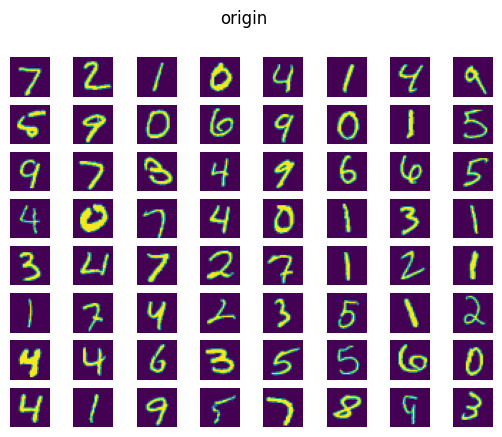

In [15]:
test_dataset=tf.data.Dataset.from_tensor_slices(x_test).batch(64).prefetch(tf.data.AUTOTUNE)
first_batch=iter(test_dataset).get_next()
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(first_batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('origin')

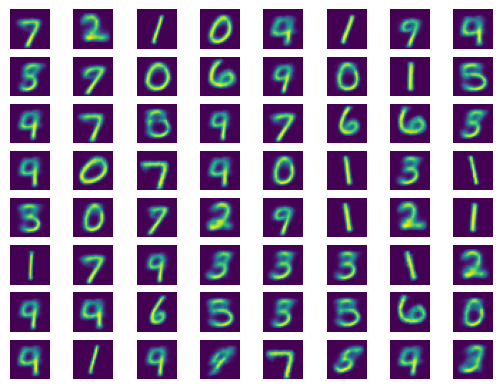

In [16]:
predicted_1batch=vae_model.decoder.predict(vae_model.encoder.predict(first_batch)[0])
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(predicted_1batch[k-1])
    plt.axis('off')
    k+=1

In [19]:
tf.saved_model.save(vae_model,'vae_2d')

INFO:tensorflow:Assets written to: vae_2d\assets


### Check latent dimension

In [25]:
(x_train,y_train),(_,_)=tf.keras.datasets.mnist.load_data()
x_train=np.expand_dims(x_train,-1).astype('float32')/255
x_train=tf.data.Dataset.from_tensor_slices(x_train).batch(64).prefetch(tf.data.AUTOTUNE)

In [27]:
first_batch=iter(x_train).get_next()

TensorShape([64, 28, 28, 1])

In [28]:
first_batch.shape

TensorShape([64, 28, 28, 1])

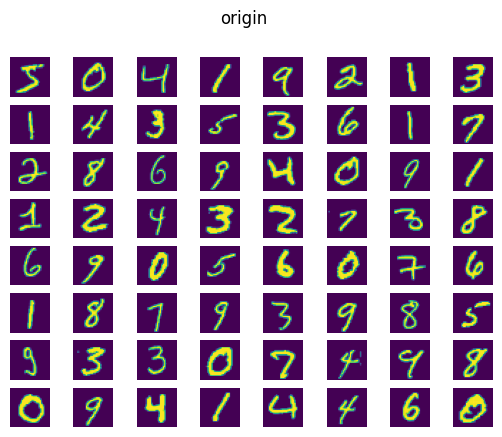

In [42]:
# original images
k=1 
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(first_batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('origin')
plt.show()

In [43]:
predicted_1batch=vae_model.decoder.predict(vae_model.encoder.predict(first_batch)[0])

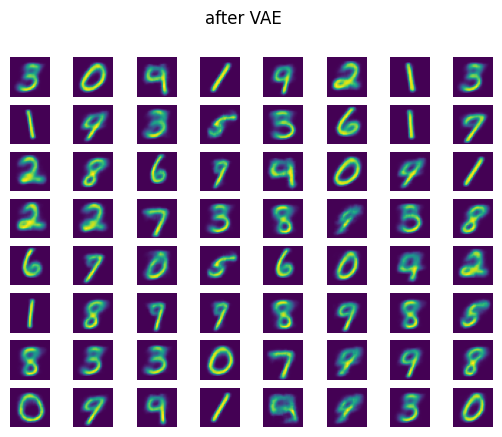

In [44]:
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(predicted_1batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('after VAE')
plt.show()

### latent space

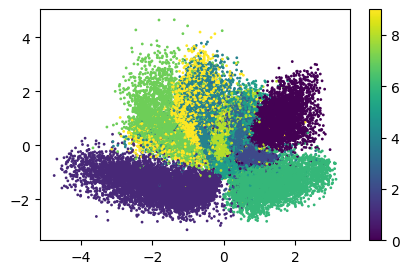

In [46]:
z,_,_=vae_model.encoder.predict(x_train)
plt.figure(figsize=(5,3))
plt.scatter(z[:,0],z[:,1],c=y_train,s=1)
plt.colorbar()
plt.show()

### Save model

In [47]:
tf.saved_model.save(vae_model,'vae_2d')

INFO:tensorflow:Assets written to: vae_2d\assets


In [48]:
vae_load_model=tf.saved_model.load('vae_2d')

In [51]:
load_predicted_batch=vae_load_model.decoder(vae_load_model.encoder(first_batch)[0])

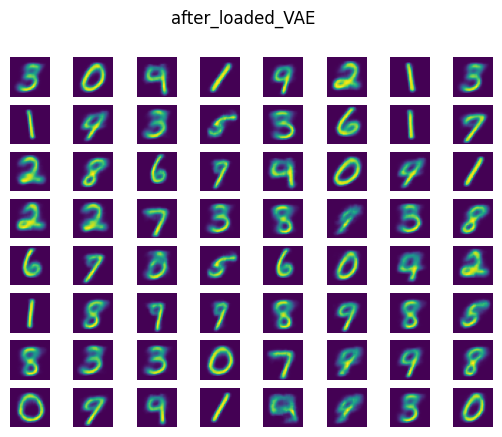

In [54]:
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(load_predicted_batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('after_loaded_VAE')
plt.show()